# Case Study: Causal Discovery (i.i.d. data)

Figure 5a and 5b

In [ ]:
import sys
sys.path = ['../'] + sys.path

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import sempler.plot
import matplotlib
import matplotlib.pyplot as plt

Did not load sempler.semi module and sempler.DRFNet class - optional dependencies are missing. See https://github.com/juangamella/sempler#installation for more details. All other functionality is available.
No module named 'rpy2'


## Auxiliary Code

#### Plot settings

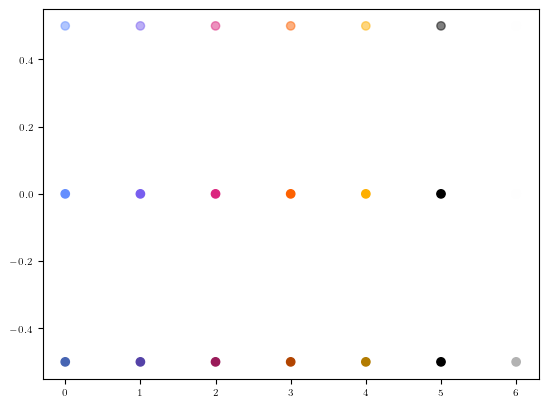

In [4]:
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

matplotlib.rcParams.update({'font.size': 7})
MM = 1/25.4 # inches to mm

def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
color_blind_1 = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4', '#020202',]
color_blind_2 = ['#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac']
color_blind_3 = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]
rainbow10 = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#7395ff", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]


# Pick one and show

palette = ibm_color_blind

base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

### Metrics for ground-truth effect recovery

Precision: $\frac{TP}{TP+FP}\quad\quad$ Recall: $\frac{TP}{P}$

In [5]:
def precision(estimate, truth):
    # TP = edges in estimate that are also in truth
    # FP + TP = total edges in estimate
    return np.logical_and(estimate,truth).sum() / estimate.sum()

def recall(estimate, truth):
    # TP = edges in estimate that are also in truth
    # P = total edges in truth
    return np.logical_and(estimate,truth).sum() / truth.sum()

## Define ground-truth graph

In [6]:
import causalchamber
from causalchamber.utils import graph_to_tikz
from causalchamber.ground_truth import latex_name


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:2404.11341},
  year={2024}
}



For standard configuration of the light tunnel we can simply take the subgraph induced by the variables we use (this is not the case for e.g. linked configuration)

In [7]:
variables = ['red', 'green', 'blue', 'current', 'ir_1', 'ir_2', 'ir_3', 'vis_1', 'vis_2', 'vis_3', 'pol_1', 'pol_2', 'angle_1', 'angle_2', 'l_11', 'l_12', 'l_21', 'l_22', 'l_31', 'l_32']

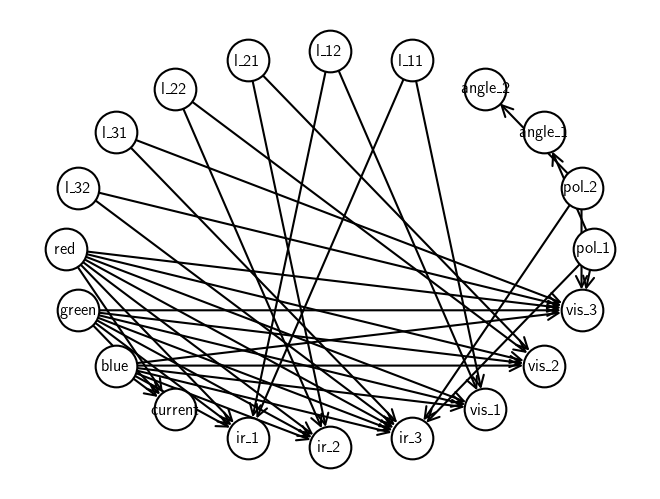

    \begin{tikzpicture}
        \node[circle, inner sep=0.12em] (0) at (-0.525, 1.617) {$R$};
        \node[circle, inner sep=0.12em] (1) at (-0.999, 1.375) {$G$};
        \node[circle, inner sep=0.12em] (2) at (-1.375, 0.999) {$B$};
        \node[circle, inner sep=0.12em] (3) at (-1.617, 0.525) {$\tilde{C}$};
        \node[circle, inner sep=0.12em] (4) at (-1.700, -0.000) {$\tilde{I}_1$};
        \node[circle, inner sep=0.12em] (5) at (-1.617, -0.525) {$\tilde{I}_2$};
        \node[circle, inner sep=0.12em] (6) at (-1.375, -0.999) {$\tilde{I}_3$};
        \node[circle, inner sep=0.12em] (7) at (-0.999, -1.375) {$\tilde{V}_1$};
        \node[circle, inner sep=0.12em] (8) at (-0.525, -1.617) {$\tilde{V}_2$};
        \node[circle, inner sep=0.12em] (9) at (0.000, -1.700) {$\tilde{V}_3$};
        \node[circle, inner sep=0.12em] (10) at (0.525, -1.617) {$\theta_1$};
        \node[circle, inner sep=0.12em] (11) at (0.999, -1.375) {$\theta_2$};
        \node[circle, inner sep=0.12em] (12) at

In [8]:
# Ground truth graph
true_dag = causalchamber.ground_truth.graph('lt', 'standard').loc[variables, variables].values
sempler.plot.plot_graph(true_dag, labels = variables)
print(graph_to_tikz(true_dag, radius=1.7, labels=[latex_name(v) for v in variables]))

## Download dataset

In [9]:
from causalchamber.datasets import Dataset
dataset = Dataset(name="lt_interventions_standard_v1", root="/tmp")

Dataset lt_interventions_standard_v1 found in "/tmp/lt_interventions_standard_v1".


In [10]:
experiments = [
    "uniform_reference",
    "uniform_red_strong",
    "uniform_green_strong",
    "uniform_blue_strong",
    "uniform_v_c_strong",
    "uniform_t_ir_1_strong",
    "uniform_t_ir_2_strong",
    "uniform_t_ir_3_strong",
    "uniform_t_vis_1_strong",
    "uniform_t_vis_2_strong",
    "uniform_t_vis_3_strong",
    "uniform_pol_1_strong",
    "uniform_pol_2_strong",
    "uniform_v_angle_1_strong",
    "uniform_v_angle_2_strong",
    "uniform_l_11_mid",
    "uniform_l_12_mid",
    "uniform_l_21_mid",
    "uniform_l_22_mid",
    "uniform_l_31_mid",
    "uniform_l_32_mid",
    
]
observational_data = dataset.get_experiment(experiments[0]).as_pandas_dataframe()[variables].values
interventional_data = [dataset.get_experiment(e).as_pandas_dataframe()[variables].values for e in experiments]

In [11]:
print("Sample sizes:")
for e,df in zip(experiments,interventional_data):
    print(f"  {len(df):<5}  {e}")

Sample sizes:
  10000  uniform_reference
  1000   uniform_red_strong
  1000   uniform_green_strong
  1000   uniform_blue_strong
  1000   uniform_v_c_strong
  1000   uniform_t_ir_1_strong
  1000   uniform_t_ir_2_strong
  1000   uniform_t_ir_3_strong
  1000   uniform_t_vis_1_strong
  1000   uniform_t_vis_2_strong
  1000   uniform_t_vis_3_strong
  1000   uniform_pol_1_strong
  1000   uniform_pol_2_strong
  1000   uniform_v_angle_1_strong
  1000   uniform_v_angle_2_strong
  1000   uniform_l_11_mid
  1000   uniform_l_12_mid
  1000   uniform_l_21_mid
  1000   uniform_l_22_mid
  1000   uniform_l_31_mid
  1000   uniform_l_32_mid


## Task a1: Observational data

#### Run GES

In [12]:
import ges

In [13]:
cpdag,_ = ges.fit_bic(observational_data, phases = ['forward', 'backward', 'turning'], debug = 0)

#### Estimated CPDAG

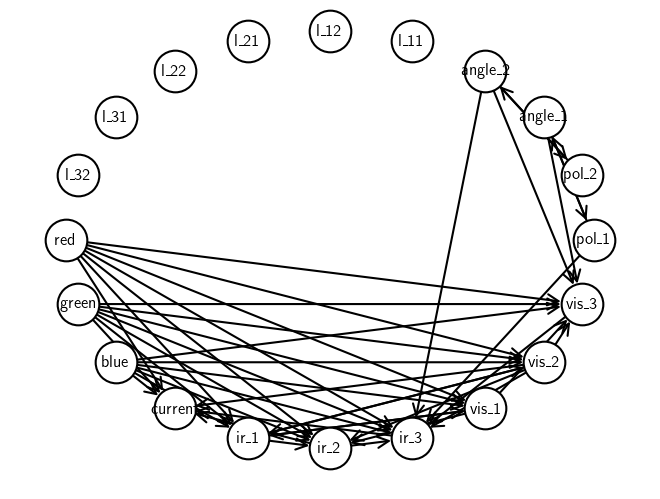

    \begin{tikzpicture}
        \node[circle, inner sep=0.12em] (0) at (-0.618, 1.902) {$R$};
        \node[circle, inner sep=0.12em] (1) at (-1.176, 1.618) {$G$};
        \node[circle, inner sep=0.12em] (2) at (-1.618, 1.176) {$B$};
        \node[circle, inner sep=0.12em] (3) at (-1.902, 0.618) {$\tilde{C}$};
        \node[circle, inner sep=0.12em] (4) at (-2.000, -0.000) {$\tilde{I}_1$};
        \node[circle, inner sep=0.12em] (5) at (-1.902, -0.618) {$\tilde{I}_2$};
        \node[circle, inner sep=0.12em] (6) at (-1.618, -1.176) {$\tilde{I}_3$};
        \node[circle, inner sep=0.12em] (7) at (-1.176, -1.618) {$\tilde{V}_1$};
        \node[circle, inner sep=0.12em] (8) at (-0.618, -1.902) {$\tilde{V}_2$};
        \node[circle, inner sep=0.12em] (9) at (0.000, -2.000) {$\tilde{V}_3$};
        \node[circle, inner sep=0.12em] (10) at (0.618, -1.902) {$\theta_1$};
        \node[circle, inner sep=0.12em] (11) at (1.176, -1.618) {$\theta_2$};
        \node[circle, inner sep=0.12em] (12) at

In [14]:
sempler.plot.plot_graph(cpdag, labels=variables)
print(graph_to_tikz(cpdag, radius=2, labels=[latex_name(v) for v in variables], bend=40, undirected="thick"))

#### Compute precision / recall for each DAG in the CPDAG

In [15]:
prec, rec = [], []
for dag in sempler.utils.all_dags(cpdag):
    prec.append(precision(dag, true_dag))
    rec.append(recall(dag, true_dag))
# Print for figure
print("precision:  ", end="")
for p in prec:
    print(("%0.2f" % p)[1:], end=" ")
print("\n   recall:  ", end="")
for r in rec:
    print(("%0.2f" % r)[1:], end=" ")

precision:  .60 .57 .57 .55 .60 .57 .57 .55 .60 .57 .57 .55 
   recall:  .62 .59 .59 .56 .62 .59 .59 .56 .62 .59 .59 .56 

## Task a2: Interventional data

#### Run UT-IGSP over a gridsearch of hyperparemeters

- $\alpha$: significance level of cond. independence tests
- $\beta$: significance level of invariance tests

In [16]:
import src.ut_igsp as ut_igsp

/home/juan/ETH/causal-chamber-paper/venv/lib/python3.8/site-packages/causaldag/utils/ci_tests/gauss_ci.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_inv(A):


In [17]:
alphas = np.linspace(1e-4,1e-2,10)
betas = np.linspace(1e-4,1e-2,10)

In [18]:
%%time
np.random.seed(42) # This doesn't fix the output of UT-IGSP below; I don't know how they manage the random state
dags = np.zeros((len(alphas), len(betas), len(variables), len(variables)))
for i,alpha in enumerate(alphas):
    for j,beta in enumerate(betas):
        print((i,j), end="\r")
        dag, _ = ut_igsp.fit(interventional_data, alpha, alpha, test='gauss')
        dags[i,j] = dag    

/home/juan/ETH/causal-chamber-paper/venv/lib/python3.8/site-packages/causaldag/utils/invariance_tests/gauss_invariance.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  ftest_stat = var1 / var2


CPU times: user 6min 55s, sys: 16min 23s, total: 23min 18s
Wall time: 2min 55s


#### Compute precision and recall for each dag

Text(0.5, 1.0, 'Recall')

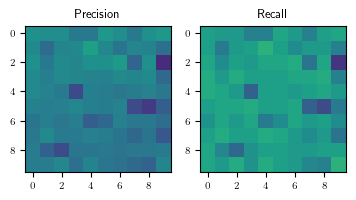

In [19]:
metrics = np.zeros((len(alphas), len(betas), 2))
for i,alpha in enumerate(alphas):
    for j,beta in enumerate(betas):
        dag = dags[i,j]
        metrics[i,j,0] = precision(dag, true_dag)
        metrics[i,j,1] = recall(dag, true_dag)
# Plot results as sanity check
plt.subplot(131)
plt.imshow(metrics[:,:,0],vmin=0,vmax=1)
plt.title("Precision")

plt.subplot(132)
plt.imshow(metrics[:,:,1],vmin=0,vmax=1)
plt.title("Recall")

#### Select best DAG for the figure as minimum L2-distance to $(1,1)$

Best (1, 4)
  precision = 0.57, recall = 0.64
  alpha = 0.0012000000000000001, beta = 0.0045000000000000005




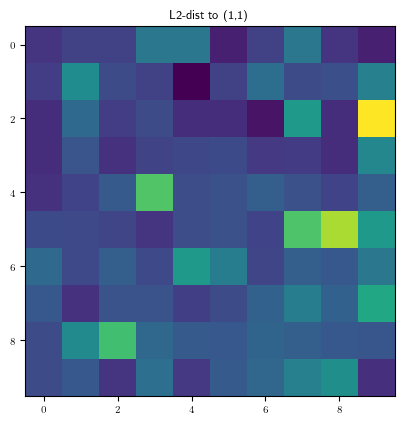

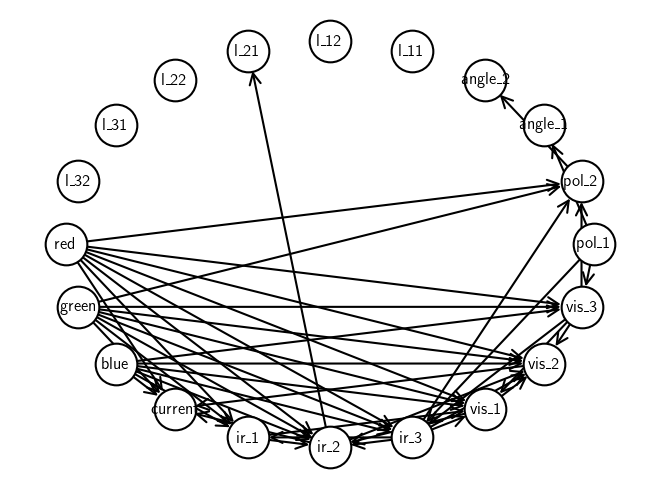

    \begin{tikzpicture}
        \node[circle, inner sep=0.12em] (0) at (-0.618, 1.902) {$R$};
        \node[circle, inner sep=0.12em] (1) at (-1.176, 1.618) {$G$};
        \node[circle, inner sep=0.12em] (2) at (-1.618, 1.176) {$B$};
        \node[circle, inner sep=0.12em] (3) at (-1.902, 0.618) {$\tilde{C}$};
        \node[circle, inner sep=0.12em] (4) at (-2.000, -0.000) {$\tilde{I}_1$};
        \node[circle, inner sep=0.12em] (5) at (-1.902, -0.618) {$\tilde{I}_2$};
        \node[circle, inner sep=0.12em] (6) at (-1.618, -1.176) {$\tilde{I}_3$};
        \node[circle, inner sep=0.12em] (7) at (-1.176, -1.618) {$\tilde{V}_1$};
        \node[circle, inner sep=0.12em] (8) at (-0.618, -1.902) {$\tilde{V}_2$};
        \node[circle, inner sep=0.12em] (9) at (0.000, -2.000) {$\tilde{V}_3$};
        \node[circle, inner sep=0.12em] (10) at (0.618, -1.902) {$\theta_1$};
        \node[circle, inner sep=0.12em] (11) at (1.176, -1.618) {$\theta_2$};
        \node[circle, inner sep=0.12em] (12) at

In [20]:
# Compute L2 - distance
l2_dist = np.sqrt(((1 - metrics)**2).sum(axis=2))
plt.imshow(l2_dist)
plt.title("L2-dist to (1,1)")
# Select best
i_best,j_best = sempler.utils.argmin(l2_dist)
best_dag = dags[i_best,j_best]
# Print stats for figure
prec,rec = metrics[i_best,j_best]
assert prec == precision(best_dag,true_dag)
assert rec == recall(best_dag,true_dag)
alpha,beta = alphas[i_best], betas[j_best]
print("Best", (i_best,j_best))
print(f"  precision = {prec:.2f}, recall = {rec:.2f}")
print(f"  alpha = {alpha}, beta = {beta}\n\n")
# Plot graph and tikz output
sempler.plot.plot_graph(best_dag, labels=variables)
print(graph_to_tikz(best_dag, radius=2, labels=[latex_name(v) for v in variables], bend=40, undirected="thick"))